# Image Debluring and Poission Stitching
- Author: Zhen Tong 120090694 
- April 1


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
Lap3x3_1 = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]])
Lap3x3_2 = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]])
Lap3x3_3 = np.array([[1, -2, 1],
                    [-2, 4, -2],
                    [1, -2, 1]])
Lap5x5 = np.array([[0, 0, -1, 0, 0],
                   [0, -1, -2, -1, 0],
                   [-1, -2, 17, -2, -1],
                   [0, -1, -2, -1, 0],
                   [0, 0, -1, 0, 0]])

_show_detail = True

def show_freq_rgb(X, title = ""):
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.subplot(131)
    plt.imshow(np.log(1 + np.abs(X[:, :, 0])), cmap='gray')
    plt.title('Red Channel Magnitude Spectrum')
    plt.colorbar()

    plt.subplot(132)
    plt.imshow(np.log(1 + np.abs(X[:, :, 1])), cmap='gray')
    plt.title('Green Channel Magnitude Spectrum')
    plt.colorbar()

    plt.subplot(133)
    plt.imshow(np.log(1 + np.abs(X[:, :, 2])), cmap='gray')
    plt.title('Red Channel Magnitude Spectrum')
    plt.colorbar()

    plt.show()

def show_freq(X, title=""):
    plt.imshow(np.log(1 + np.abs(X[:, :])), cmap='gray')
    plt.title(title)
    plt.colorbar()

def get_denoise(B, H, L, lbd, N = None):
    X = np.zeros_like(B)
    H_2 = np.square(H)
    H_conj = np.conj(H)
    L_2 = np.square(L)
    for i in range(3):
        B_subChannle = B[:, :, i]
        if N is not None:
            X[:, :, i] = (H_conj*(B_subChannle+N[:, :, i])) / (H_2 + lbd*L_2)
        else:
            X[:, :, i] = (H_conj*B_subChannle) / (H_2 + lbd*L_2)
    return X


(711, 711, 3)


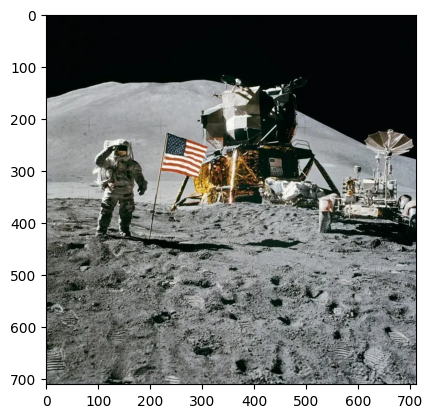

In [2]:
# img_path = "../data/a44w9-kvhmn.jpg"
img_path = "../data/Apollo_15_flag_rover_LM_Irwin-1200x1200.jpg"
src_img = cv2.imread(img_path)
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB); 
plt.imshow(src_img)
print(src_img.shape)

### Part 0: Patchify the Image Robust.

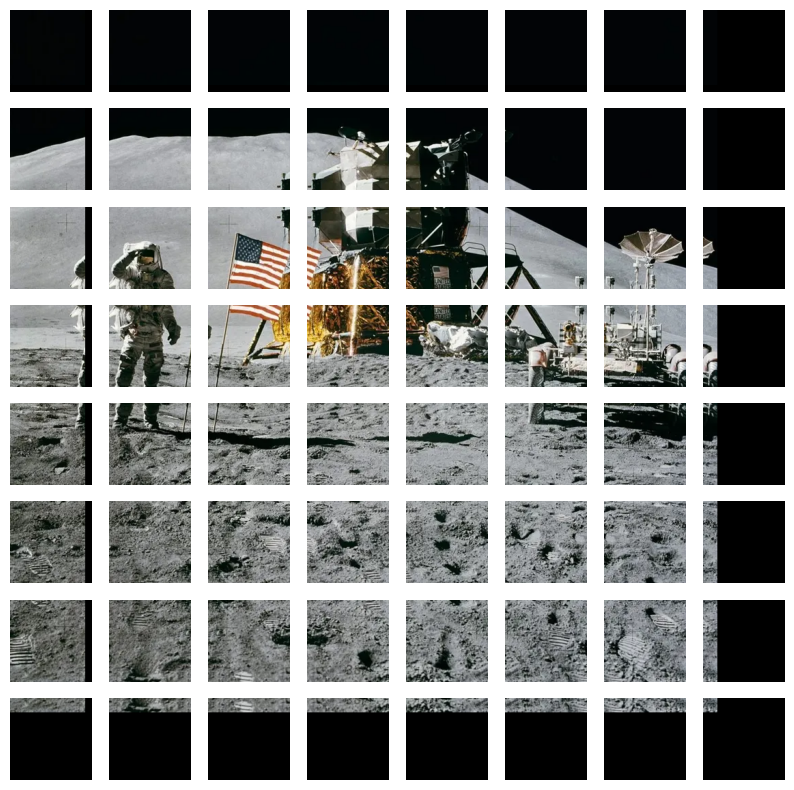

In [3]:
def patchify(img:np.ndarray, p_size, m_size):
    """
    input the image, output the patches image with overlap margin
    """
    h, w, _ = img.shape
    x_pos = [i for i in range(0, h, p_size)]
    y_pos = [i for i in range(0, w, p_size)]

    patch_grid = []
    label_grid = []
    for x in x_pos:
        row = []
        row_lable = []
        for y in y_pos:
            patch_x0 = x-m_size
            patch_x1 = x+p_size+m_size
            patch_y0 = y-m_size
            patch_y1 = y+p_size+m_size
            ele_label = [True, True, True, True]
            if x-m_size < 0:
                patch_x0 = 0
                ele_label[0] = False
            if x+p_size+m_size > h:
                patch_x1 = h
                ele_label[1] = False
            if y-m_size < 0:
                patch_y0 = 0
                ele_label[2] = False
            if y+p_size+m_size > w:
                patch_y1 = w
                ele_label[3] = False
            row.append(img[patch_x0:patch_x1, patch_y0:patch_y1])
            row_lable.append(ele_label)
        patch_grid.append(row)
        label_grid.append(row_lable)
    return patch_grid, label_grid

def resize_image(image, target_size):
    if image.shape == target_size:
        return image.astype(np.int64)
    else:
        target_img = np.zeros(target_size)
        target_img[:image.shape[0], :image.shape[1], :] = image
        return target_img.astype(np.int64)

def plot_images(image_array, rows, cols, p_size, m_size):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    target_size = (p_size+2*m_size, p_size+2*m_size, 3)
    
    for i in range(rows):
        for j in range(cols):

            axes[i, j].imshow(resize_image(image_array[i][j], target_size))
            axes[i, j].axis('off')

    plt.show()
    
p_size = 100
m_size = 10
patches, label_list = patchify(src_img, p_size, m_size)
if _show_detail:
    plot_images(patches, len(patches), len(patches[0]), p_size, m_size)

###   Part 1. The "Constrained Least Squares Filtering" (CLSF)
####  Step 0. Get the noised Image

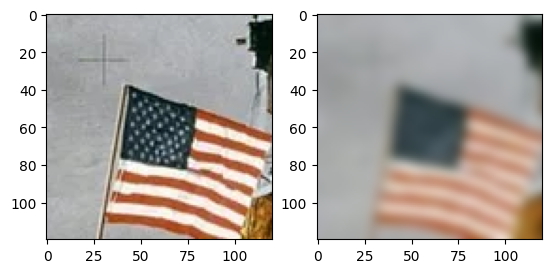

In [4]:
def get_gaussian_kernel(k_size, sigma = 3):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(k_size-1)/2)**2 + (y-(k_size-1)/2)**2)/(2*sigma**2)), (k_size, k_size))
    return kernel / np.sum(kernel)

def get_laplacian_kernel(k_size):
    kernel = np.zeros((k_size, k_size))
    return kernel

def add_gaussian_noise(img:np.ndarray, noise_add = True, k_size = 17, sigma0 = 3, \
                        sigma_r = 0.01, sigma_g = 0.03, sigma_b = 0.1):
    
    kernel = get_gaussian_kernel(k_size, sigma0)
    b_x = np.zeros_like(img).astype(np.float64)
    for i in range(3):  # 3 channels for RGB
        b_x[:,:,i] = cv2.filter2D(img[:,:,i], -1, kernel, borderType=cv2.BORDER_REPLICATE)


    h, w, c = img.shape    
    noise = np.zeros_like(img)
    if noise_add:
        noise[:, :, 0] = np.random.normal(0, sigma_r, (h, w))
        noise[:, :, 1] = np.random.normal(0, sigma_g, (h, w))
        noise[:, :, 2] = np.random.normal(0, sigma_b, (h, w))

    b_x += noise
    return b_x.astype(np.int32), kernel, noise
    
img =       patches[2][2]
label = label_list [2][2]
x0, x1, y0, y1 = 0, img.shape[0], 0, img.shape[1]
if label[0]:
    x0 += m_size
if label[1]:
    x1 -= m_size
if label[2]:
    y0 += m_size
if label[3]:
    y1 -= m_size
bias_img, gaussian_kernel, noise = add_gaussian_noise(img)
# img = img[x0:x1, y0:y1]
# bias_img = bias_img[x0:x1, y0:y1]
if _show_detail:
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(bias_img)

#### Step 1. Frequency Domain Transformation

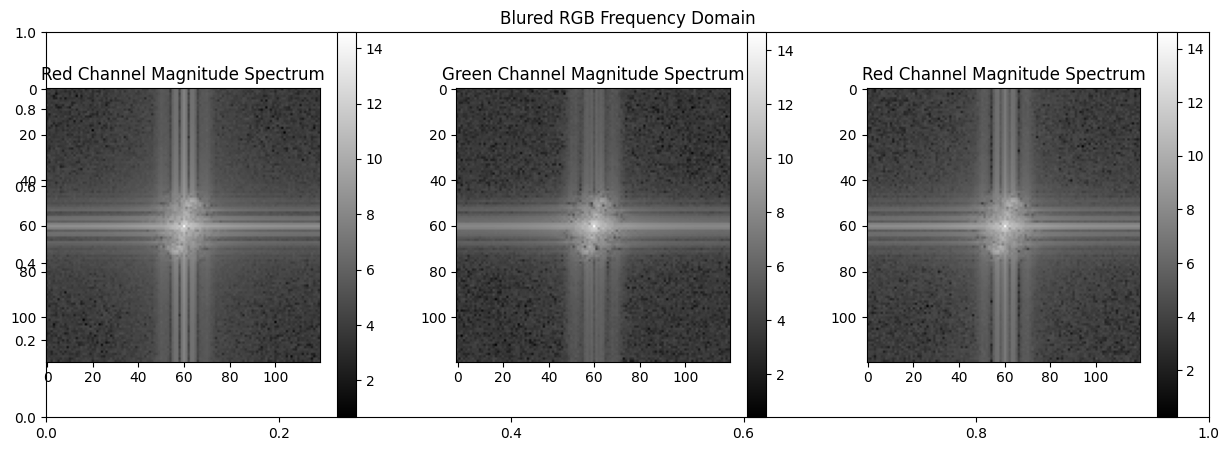

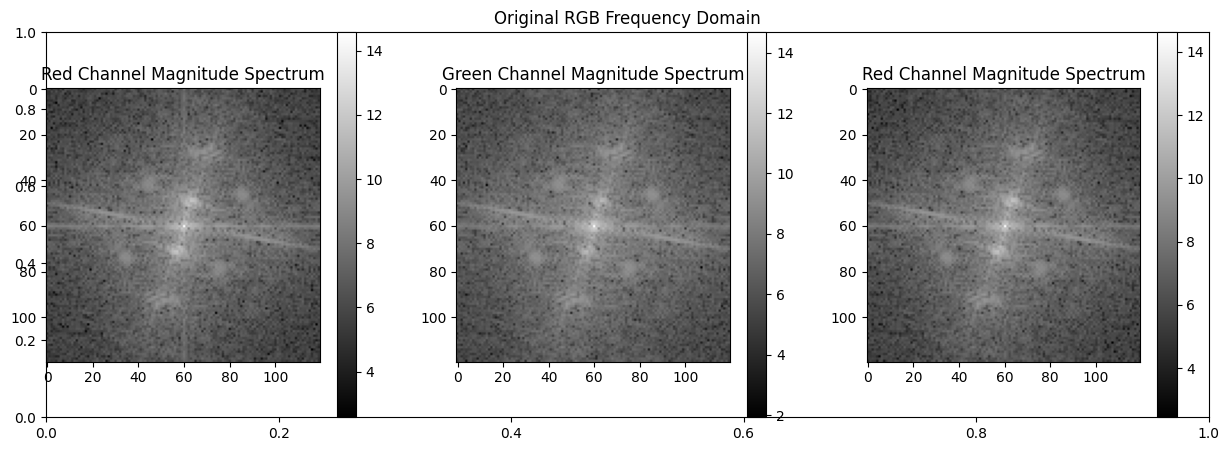

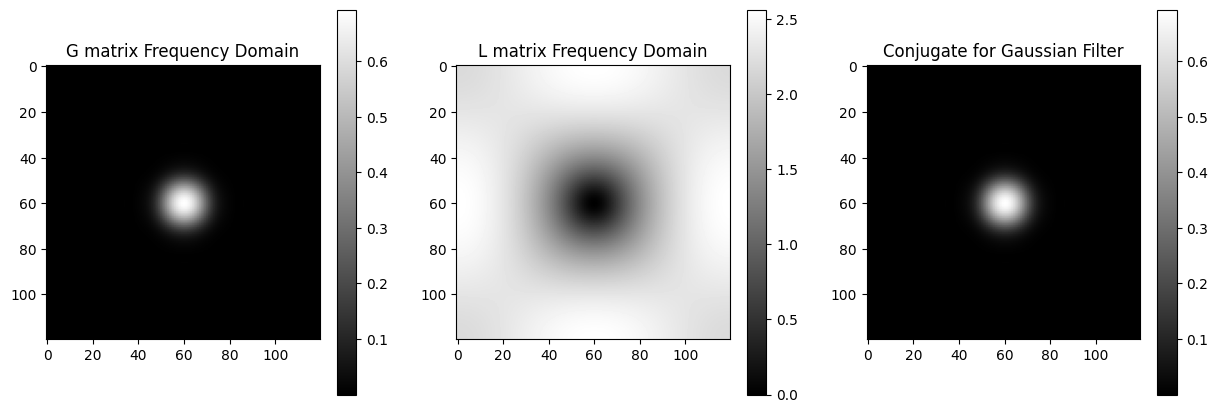

In [5]:
def get_frequency_domain_rgb(img, f_size, shift = False):
    if shift:
        X = [np.fft.fftshift(np.fft.fft2(img[:, :, i], s=f_size)) for i in range(3)]
    else:
        X = [np.fft.fft2(img[:, :, i], s=f_size) for i in range(3)]
    # TODO merge the X into a three channel rgb matrix in frquency domain
    merged_real = cv2.merge([np.real(channel) for channel in X])
    merged_imag = cv2.merge([np.imag(channel) for channel in X])
    merged_complex = merged_real + 1j * merged_imag
    return merged_complex

f_size = (img.shape[0], img.shape[1])
B = get_frequency_domain_rgb(bias_img, f_size)
S = get_frequency_domain_rgb(img, f_size)
N = get_frequency_domain_rgb(noise, f_size)
B_shift = np.fft.fftshift(B)
S_shift = np.fft.fftshift(S)

G_matrix = np.fft.fft2(gaussian_kernel, s=f_size)
G_matrix_shift = np.fft.fftshift(G_matrix)

L_matrix = np.fft.fft2(Lap3x3_2, s=f_size)
L_matrix_shift = np.fft.fftshift(L_matrix)

if _show_detail:
    show_freq_rgb(B_shift, title="Blured RGB Frequency Domain")
    show_freq_rgb(S_shift, title="Original RGB Frequency Domain")
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    show_freq(G_matrix_shift, "G matrix Frequency Domain")
    plt.subplot(132)
    show_freq(L_matrix_shift, "L matrix Frequency Domain")
    plt.subplot(133)
    show_freq(np.conj(G_matrix_shift), "Conjugate for Gaussian Filter")
    plt.show()


#### Step 2. Solve The Object Function in Frequency Domain
$$E(X) = ||H \cdot X -B||^2 + \lambda||L \cdot X||^2 \\

X = \frac{H^*\cdot B}{||H||^2+\lambda||L||^2}
$$

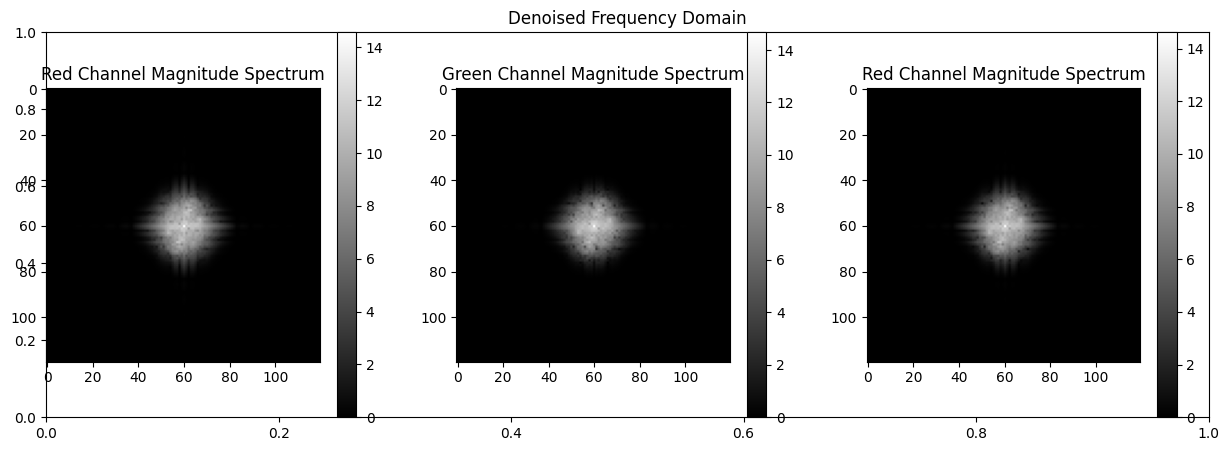

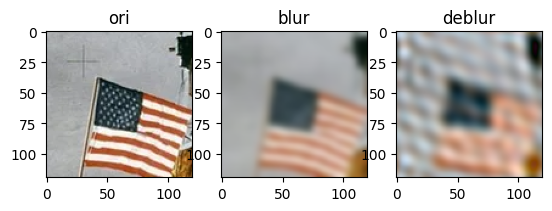

In [6]:
def get_spatial_domain_rbg(X, img_size):
    x = np.zeros(img_size)
    for i in range(3):
        x[:, :, i] = np.abs(np.fft.ifft2(X[:, :, i]))   
    img = np.zeros(img_size)
    h_mid = int(img_size[0]*0.8)
    w_mid = int(img_size[1]*0.8)
    h_shift = img_size[0]-h_mid
    w_shift = img_size[1]-w_mid
    img[:h_shift, :w_shift] = x[h_mid:, w_mid:]
    img[:h_shift, w_shift:] = x[h_mid:, :w_mid]
    img[h_shift:, :w_shift] = x[:h_mid, w_mid:]
    img[h_shift:, w_shift:] = x[:h_mid, :w_mid]
    return img.astype(np.int32)

lbd = 1.4
X = get_denoise(B, G_matrix, L_matrix, lbd, N)
f2img = get_spatial_domain_rbg(X, img.shape)
X_shift = np.fft.fftshift(X)


if _show_detail:
    show_freq_rgb(X_shift, "Denoised Frequency Domain")
    plt.subplot(131);plt.imshow(img);plt.title("ori")
    plt.subplot(132);plt.imshow(bias_img);plt.title("blur")
    plt.subplot(133);plt.imshow(f2img);plt.title("deblur")


### Part 3: Image Stitching with Poission Blending
#### Step 1: Generate Mask and Patch Blur

(711, 711) (715, 715)


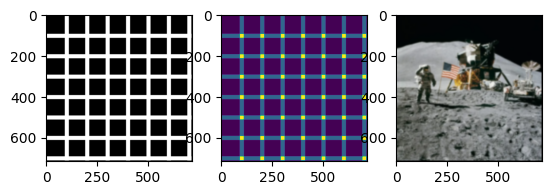

In [7]:
from scipy.sparse import csr_matrix, lil_matrix, linalg
from copy import deepcopy

pad_size = 2

mask = np.zeros((src_img.shape[0], src_img.shape[1]))
pad_img = np.zeros((src_img.shape[0]+pad_size*2, src_img.shape[1]+pad_size*2, 3))
blur_list = []
for i, patch_row in enumerate(patches):
    blur_row = []
    for j, patch in enumerate(patch_row):
        label = label_list[i][j]
        x0, y0 = i*p_size, j*p_size

        if label[0]:
            x0-=m_size
        if label[2]:
            y0-=m_size
        x1 = x0+patch.shape[0]
        y1 = y0+patch.shape[1]
        
        mask[x0:x1, y0:y1] +=1
        bias_patch, _, _ = add_gaussian_noise(patch)
        pad_img[x0+pad_size:x1+pad_size, y0+pad_size:y1+pad_size] += bias_patch
        blur_row.append(bias_patch)
    blur_list.append(blur_row)


pad_mask = np.pad(mask, ((pad_size, pad_size), (pad_size, pad_size)), mode="constant", constant_values=1)-1
pad_mask_cal = deepcopy(pad_mask)+1
pad_mask[pad_mask>0] = 1
plt.subplot(131);plt.imshow(pad_mask, cmap="gray")
plt.subplot(132);plt.imshow(pad_mask_cal)
for i in range(3):
    pad_img[:, :, i] /= pad_mask_cal
plt.subplot(133);plt.imshow(pad_img.astype(np.int32))
print(mask.shape, pad_mask.shape)



Step 2: Patch by Patch Deblur

In [8]:
deblur_list = []
pad_deblur_img = np.zeros_like(pad_img)
for i, row in enumerate(blur_list):
    deblur_row = []
    for j, blur in enumerate(row):
        # Compute deblur
        f_size = (blur.shape[0], blur.shape[1])
        B = get_frequency_domain_rgb(blur, f_size)
        G_matrix = np.fft.fft2(gaussian_kernel, s=f_size)
        L_matrix = np.fft.fft2(Lap3x3_2, s=f_size)
        X = get_denoise(B, G_matrix, L_matrix, 1.5)
        deblur = get_spatial_domain_rbg(X, patches[i][j].shape)
        deblur_row.append(deblur)

        # add it in the result
        label = label_list[i][j]
        x0, y0 = i*p_size, j*p_size
        if label[0]:
            x0-=m_size
        if label[2]:
            y0-=m_size
        x1 = x0+deblur.shape[0]
        y1 = y0+deblur.shape[1]
        pad_deblur_img[x0+pad_size:x1+pad_size, y0+pad_size:y1+pad_size] = deblur

    deblur_list.append(deblur_row)


# for i in range(3):
    # pad_deblur_img[:, :, i] /= pad_mask_cal


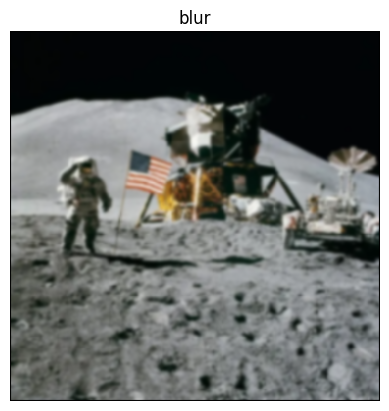

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


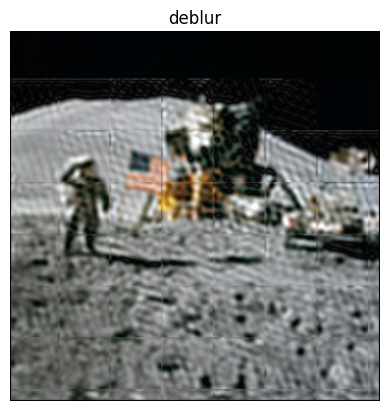

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


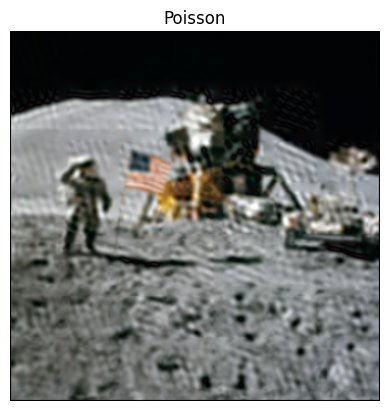

(<matplotlib.image.AxesImage at 0x12a3f4940>, None)

In [14]:
def seamlessClone(src,dst,mask,flag):
    # 1. 求源图像的散度
    laplacian = cv2.Laplacian(np.float64(src),ddepth=-1,ksize=1)

    # 6. 求融合散度
    if flag == 1:
        kernel = [np.array([[0, -1, 1]]),np.array([[1, -1, 0]]), np.array([[0], [-1], [1]]), np.array([[1], [-1], [0]])] # 四个方向梯度的过滤器，分别为x正方向、x反方向、y正方向、y反方向，散度就是在同一个方向进行两次梯度计算
        # 求src图、dst梯度
        grads = []
        for i in range(4):
            srcGrad = cv2.filter2D(np.float64(src), -1, kernel[i])
            dstGrad = cv2.filter2D(np.float64(dst), -1, kernel[i])
            grads.append(np.where(np.abs(srcGrad) > np.abs(dstGrad), srcGrad, dstGrad)) # 哪个梯度大就取哪个
        laplacian = np.sum(grads, axis=0) # 四个梯度求和，即两个散度求和，得到最终的散度 
    # 7. 逐通道求解
    result = [getX(a, mask, b) for a, b in zip(cv2.split(dst), cv2.split(laplacian))]
    
    # 合并三个通道
    final = cv2.merge(result)
    return final


def getX(dst, mask, lap):
    # 1 计算求解的像素个数
    loc = np.nonzero(mask)
    num = loc[0].shape[0] 
    # 2. 有多少个像素个数则需要多少个方程，需要构造num*num大小的稀疏矩阵和num大小的b向量
    # 3. A用lilmatrix，这种矩阵方便逐个添加
    A = lil_matrix((num, num), dtype=np.float64)
    b = np.ndarray((num, ), dtype=np.float64) # 一维数组,长度只有1, 而且最外层的长度为num
    # 4. 要将每个像素映射到0~num-1的索引之中，因为A系数矩阵也是根据索引求构造的
    hhash = {(x, y): i for i, (x, y) in enumerate(zip(loc[0], loc[1]))}
    # 用于找上下左右四个像素位置
    dx = [1,0,-1,0]
    dy = [0,1,0,-1]
    # 5. 构造A系数矩阵和b向量 
    for i, (x, y) in enumerate(zip(loc[0],loc[1])):
        A[i, i] = -4
        b[i] = lap[x, y]
        p = [(x + dx[j], y + dy[j]) for j in range(4)] # p为上下左右的像素位置
        for j in range(4):
            if p[j] in hhash: # 像素位置在mask内
                A[i, hhash[p[j]]] = 1
            else:
                b[i] -= dst[p[j]]
                
    # 由于A是稀疏矩阵，可以将lilmatrix转成cscmatrix，方便矩阵运算
    A = A.tocsc()
    # 6. 求解X
    X = linalg.splu(A).solve(b)

    # 7. 将X复制到对应位置
    result = np.copy(dst)
    for i, (x, y) in enumerate(zip(loc[0],loc[1])):
        if X[i] < 0:
            X[i] = 0
        if X[i] > 255:
            X[i] = 255
        result[x, y] = X[i]

    return result

output = seamlessClone(pad_img, pad_deblur_img, pad_mask, 0)
plt.axis("off");plt.title("blur");plt.imshow(pad_img.astype(np.int32));plt.show()
plt.axis("off");plt.title("deblur");plt.imshow(pad_deblur_img.astype(np.int32));plt.show()
plt.axis("off");plt.title("Poisson");plt.imshow(output.astype(np.int32)), plt.show()